## Spotify Skip RL Model

Elise Rust 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import warnings
from itertools import tee

# Suppress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

warnings.filterwarnings("ignore")

/opt/anaconda3/envs/anly591/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Pre-Processing
1. Join session level data with track context/features
2. Identify all unique transitions from song a to song b --> store in dictionary
3. Convert rewards to binary 0 = skipped, 1 = not skipped
4. Encode categorical track and session features
5. Create Features dataframe which containes cleaned/OHE vector of track features
6. Generate session context encoding
    - How each session has responded to tracks of given features
    - Multiply feature by 1 if user didn't skip, 0 (nullified) if user did skip
    - If a session skipped 3 songs with high valence, and didn't skip 1 song with high danceability their encoding would look like:
    
|duration|us_popularity|acousticness|beat_strength|bounciness|danceability|dyn_range|energy|flatness|etc.
|------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
|   109.5|      99.2|      0.5|      0.7|      0.3|      0.2|      0.2|      7.5|      0.8|      etc.|

Normalize the session level response to song features on a 0-1 scale


In [2]:
# Load in Data
df_sessions_sampled = pd.read_csv('data/training_set/log_sampled.csv')
df_tracks_sampled = pd.read_csv('data/track_features/tf_sampled.csv')
print("Number of sessions in DF: " + str(len(df_sessions_sampled['session_id'].unique())))
print("Number of tracks in DF: " + str(len(df_tracks_sampled['track_id'].unique())))
# Sanity check num tracks in tracks df equals num tracks in sessions df
assert len(df_sessions_sampled['track_id_clean'].unique()) == len(df_tracks_sampled['track_id'].unique())

Number of sessions in DF: 178342
Number of tracks in DF: 319008


In [3]:
## Check for nulls, etc.
print("Missing values in sessions data: ", df_sessions_sampled.isna().sum())
print("Missing values in track data: ", df_sessions_sampled.isna().sum())

Missing values in sessions data:  session_id                         0
session_position                   0
session_length                     0
track_id_clean                     0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
date                               0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
dtype: int64
Missing values in track data:  session_id                         0
session_position                   0
session_length                     0
track_id_clean                    

In [4]:
## Examine columns and datatypes in each dataframe
print(df_sessions_sampled.dtypes)
print("-----------------------")
print(df_tracks_sampled.dtypes)

session_id                         object
session_position                    int64
session_length                      int64
track_id_clean                     object
skip_1                               bool
skip_2                               bool
skip_3                               bool
not_skipped                          bool
context_switch                      int64
no_pause_before_play                int64
short_pause_before_play             int64
long_pause_before_play              int64
hist_user_behavior_n_seekfwd        int64
hist_user_behavior_n_seekback       int64
hist_user_behavior_is_shuffle        bool
hour_of_day                         int64
date                               object
premium                              bool
context_type                       object
hist_user_behavior_reason_start    object
hist_user_behavior_reason_end      object
dtype: object
-----------------------
track_id                   object
duration                  float64
release_year

In [5]:
## Join dataframes together on 'track_id'
spotify = df_sessions_sampled.merge(df_tracks_sampled, left_on="track_id_clean", right_on="track_id")
print(spotify.isna().sum())
spotify.head()

session_id                         0
session_position                   0
session_length                     0
track_id_clean                     0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
date                               0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
track_id                           0
duration                           0
release_year                       0
us_popularity_estimate             0
acousticness                       0
beat_strength                      0
b

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,1,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21


In [6]:
## Drop unnecessary columns
# spotify = spotify.drop(columns=['hist_user_behavior_reason_start', 'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7'])
spotify = spotify.drop(columns=['acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7'])

In [8]:
## Count unique songs
print("Unique songs in dataset: ", len(spotify.track_id.unique()))

## Map how many unique transitions between song x and song y exist
def pairwise(iterable):
    a,b = tee(iterable)
    next(b, None)
    return zip(a,b)

def count_transitions(df=spotify, track_id='track_id', seq='session_position'):
    '''
    Inputs:
    - A dataframe
    - Column containing unique track ids
    - Sequence column indicating the position in session each track is in

    NOTE: This method is insanely inefficient if anyone has suggestions
    '''

    unique_transitions = [] # Count number of unique transitions
    transitions_dict = {} # Store unique tracks each song can transition to
    for s in df.track_id.unique(): # Set unique tracks as keys
        transitions_dict[s] = []

    for (i1, row1), (i2, row2) in pairwise(spotify.iterrows()):
        # Loop through all pairs of tracks --> not efficient but should do the trick
        track1 = row1['track_id']
        track2 = row2['track_id']
        position1 = row1['session_position']
        position2 = row2['session_position']
        # Boolean initialization
        transition=False
        unique=False

        if [track1, track2] not in unique_transitions:
            unique = True
        if position2 == position1+1: # If the tracks are sequential
            transition = True
            transitions_dict[track1].append(track2)
        
        if (unique and transition):
            unique_transitions.append([track1, track2])
        
    
    return transitions_dict, (len(unique_transitions))
    
transitions_dict, num_transitions = count_transitions()

Unique songs in dataset:  319008


In [30]:
print("Number of unique song transitions in dataframe: ", num_transitions)
print(dict(list(transitions_dict.items())[0: 1]))

Number of unique song transitions in dataframe:  133873
{'t_0479f24c-27d2-46d6-a00c-7ec928f2b539': ['t_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-46d6-a00c-7ec928f2b539', 't_0479f24c-27d2-4

#### Encode rewards
- The agent learns via the 'skip' variables (this is how we get feedback on whether the user likes or doesn't like a given song)
- Convert 'skip_1', 'skip_2', 'skip_3', 'not_skipped' into binary 'skip' variable (1/0; 0 if user skips)

Reward is thus:
+1 if song is not skipped
-1 if song is skipped

In [7]:
spotify['response'] = np.where(
    spotify['not_skipped']==True,
    1,
    -1
)
spotify = spotify.drop(columns=['skip_1', 'skip_2', 'skip_3', 'not_skipped'])
spotify.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,response
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,1
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,-1
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,1
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,1
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,-1


In [8]:
spotify.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'response'],
      dtype='object')

## Encode relevant user context data - behavior
To booleans:
- shuffle (0/1)
- premium (0/1)

To numeric:
- date --> year, month

To OHE vectors:
- context (catalog, charts, editorial playlist, personalized playlist, radio, user collection)
- track end reason (appload, backbtn, clickrow, endplay, fwdbtn, logout, remote, trackdone)

In [9]:
# Convert binary columns to booleans
data_bool_cols = spotify.columns[spotify.dtypes=='bool']
for col in data_bool_cols:
    spotify[col]=spotify[col].astype(int)
# spotify['mode'] = spotify['mode'].astype(bool).astype(int)
# spotify['mode'].value_counts()
spotify['mode'].replace(['major', 'minor'], [0, 1], inplace=True)#.value_counts()

In [10]:
spotify['mode'].value_counts()

0    1828327
1    1162282
Name: mode, dtype: int64

In [11]:
from datetime import datetime

# spotify['date'] = pd.to_datetime(spotify.date, format='%Y-%m-%d')
# spotify['year']=spotify['date'].dt.year
# spotify['month']=spotify['date'].dt.month
# spotify = spotify.drop(columns='date')
spotify.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,response
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.68,-6.58,0.55,0,0.32,0.07,134.02,4,0.15,1
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,0,0.32,0.07,134.02,4,0.15,-1
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,0,0.32,0.07,134.02,4,0.15,1
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.68,-6.58,0.55,0,0.32,0.07,134.02,4,0.15,1
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,0,0.32,0.07,134.02,4,0.15,-1


In [12]:
# OHE Categorical Columns
categorical_columns =['context_type', 'hist_user_behavior_reason_end']
enc = OneHotEncoder()
array_hot_encoded = enc.fit_transform(spotify[categorical_columns]).toarray()
feature_labels = enc.categories_
feature_labels = np.concatenate(feature_labels, axis=0)
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns=feature_labels, index=spotify.index) # Convert OHE array to df
spotify = spotify.drop(columns=categorical_columns)
spotify_enc = pd.concat([spotify, data_hot_encoded], axis=1)
spotify_enc.head()



,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,appload,backbtn,clickrow,endplay,fwdbtn,logout,popup,remote,trackdone,uriopen
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


### Session Context Encoding - track preferences

In [13]:
feature_columns = ['duration', 'release_year', 'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mechanism', 'mode', 'organism', 'speechiness', 'tempo', 'time_signature', 'valence',
       'response', 'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',] # removed 'mode'

In [14]:
for i in feature_columns:
    print(spotify_enc[i])

0                       180.07
1                       180.07
2                       180.07
3                       180.07
4                       180.07
                  ...         
2990604                 291.76
2990605                 241.55
2990606                 241.55
2990607                 111.08
2990608                 126.07
Name: duration, Length: 2990609, dtype: float64
0          2018
1          2018
2          2018
3          2018
4          2018
           ... 
2990604    2013
2990605    2013
2990606    2013
2990607    2013
2990608    2014
Name: release_year, Length: 2990609, dtype: int64
0                        99.97
1                        99.97
2                        99.97
3                        99.97
4                        99.97
                  ...         
2990604                  99.92
2990605                  99.72
2990606                  99.72
2990607                  99.55
2990608                  98.20
Name: us_popularity_estimate, Length: 299060

In [15]:
# Normalize all features to be between 0 and 1
for i in feature_columns:
    # print(i)
    #spotify_enc[i] /= np.max(np.abs(spotify_enc[i]),axis=0) # Between -1 and 1
    spotify_enc[i] = (spotify_enc[i]-np.min(spotify_enc[i]))/(np.max(spotify_enc[i])-np.min(spotify_enc[i]))

In [16]:
def encode_track_preferences(session_responses, feature_columns):
    '''
    Input:
    session_responses = dataframe of session (track features, behavior, etc.)
    song_context = list of variables related to track features
    '''

    # Get reviews of songs (1 vs. 0 skip outcome) * track features
    ratings = session_responses[feature_columns].mul(session_responses['response'], axis=0)
    
    # Average across session --> one vector per session
    session_pref = ratings.mean(axis=0)
    #print(session_pref)

    return session_pref

# spotify_enc.groupby('session_id').apply(lambda x: encode_track_preferences(x, feature_columns))

In [17]:
session_id_avg = spotify_enc.groupby('session_id').apply(lambda x: encode_track_preferences(x, feature_columns))
session_id_avg

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,response,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.03,0.30,0.30,0.06,0.19,0.21,0.24,0.08,0.17,0.27,...,0.24,0.14,0.30,0.00,0.25,0.00,0.00,0.00,0.00,0.30
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.07,0.19,0.22,0.03,0.11,0.11,0.14,0.05,0.23,0.25,...,0.24,0.16,0.30,0.00,0.25,0.05,0.05,0.00,0.00,0.30
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.01,0.10,0.10,0.01,0.07,0.08,0.08,0.03,0.05,0.09,...,0.08,0.05,0.10,0.00,0.05,0.00,0.05,0.00,0.00,0.00
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.02,0.19,0.20,0.02,0.11,0.11,0.14,0.04,0.16,0.17,...,0.16,0.15,0.20,0.00,0.10,0.10,0.10,0.00,0.00,0.00
0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.05,0.55,0.55,0.01,0.27,0.28,0.37,0.11,0.41,0.48,...,0.44,0.34,0.55,0.00,0.55,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_fffddbbf-5972-4239-8687-896a315a1d87,0.07,0.69,0.69,0.08,0.41,0.44,0.51,0.17,0.47,0.63,...,0.56,0.31,0.70,0.05,0.65,0.00,0.05,0.00,0.00,0.45
0_fffe8971-eac0-48e8-88d0-ffaec467bad2,0.03,0.31,0.31,0.07,0.21,0.24,0.25,0.09,0.14,0.28,...,0.25,0.10,0.31,0.00,0.23,0.00,0.00,0.00,0.00,0.00
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf,0.09,0.58,0.72,0.31,0.23,0.22,0.28,0.11,0.38,0.64,...,0.56,0.27,0.72,0.00,0.44,0.28,0.28,0.00,0.00,0.72


In [18]:
# CHECK WHICH COLUMNS HAVE MISSING VALUES
for col in session_id_avg.columns:
    if session_id_avg[col].isnull().values.any():
        print(f'{col} contains NaN values')

# DROP COLUMNS WITH MISSING VALUES
# session_id_avg = session_id_avg.drop(['mode'], axis=1)

In [19]:
session_id_avg.head()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,response,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.03,0.30,0.30,0.06,0.19,0.21,0.24,0.08,0.17,0.27,...,0.24,0.14,0.30,0.00,0.25,0.00,0.00,0.00,0.00,0.30
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.07,0.19,0.22,0.03,0.11,0.11,0.14,0.05,0.23,0.25,...,0.24,0.16,0.30,0.00,0.25,0.05,0.05,0.00,0.00,0.30
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.01,0.10,0.10,0.01,0.07,0.08,0.08,0.03,0.05,0.09,...,0.08,0.05,0.10,0.00,0.05,0.00,0.05,0.00,0.00,0.00
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.02,0.19,0.20,0.02,0.11,0.11,0.14,0.04,0.16,0.17,...,0.16,0.15,0.20,0.00,0.10,0.10,0.10,0.00,0.00,0.00
0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.05,0.55,0.55,0.01,0.27,0.28,0.37,0.11,0.41,0.48,...,0.44,0.34,0.55,0.00,0.55,0.00,0.00,0.00,0.00,0.00


In [20]:
session_id_avg.iloc[[2]]

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,response,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle
session_id,,,,,,,,,,,,,,,,,,,,,
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.01,0.10,0.10,0.01,0.07,0.08,0.08,0.03,0.05,0.09,...,0.08,0.05,0.10,0.00,0.05,0.00,0.05,0.00,0.00,0.00


In [21]:
def cosine_sim(A, B):
    # Calculate dot product of v1 and v2
    dot_product = np.dot(A, B)
    
    # Calculate the norm (magnitude) of v1
    norm_A = np.linalg.norm(A)
    
    # Calculate the norm (magnitude) of v2
    norm_B = np.linalg.norm(B)
    
    # Divide the dot product of v1 and v2 by the product of their norms to get cosine similarity score
    cosine_similarity = dot_product / (norm_A * norm_B)
    
    # Return the cosine similarity score
    return cosine_similarity

In [22]:
session_id_avg.iloc[0, :]

duration                                        0.03
release_year                                    0.30
us_popularity_estimate                          0.30
acousticness                                    0.06
beat_strength                                   0.19
bounciness                                      0.21
danceability                                    0.24
dyn_range_mean                                  0.08
energy                                          0.17
flatness                                        0.27
instrumentalness                                0.00
key                                             0.12
liveness                                        0.06
loudness                                        0.25
mechanism                                       0.20
mode                                            0.05
organism                                        0.10
speechiness                                     0.05
tempo                                         

In [23]:
print('How close in similarity is the first listening session with itself? ',cosine_sim(session_id_avg.iloc[0, :], session_id_avg.iloc[0, :]))
print('How close in similarity is the first listening session with the second? ',cosine_sim(session_id_avg.iloc[0, :], session_id_avg.iloc[1, :]))

How close in similarity is the first listening session with itself?  1.0000000000000002
How close in similarity is the first listening session with the second?  0.9345141268209695


In [24]:
test_session = spotify_enc[spotify_enc['session_id']==session_id_avg.index[0]][feature_columns]
test_session

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,response,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle
0,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,0.92,...,0.80,0.15,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
865,0.12,1.00,0.99,0.06,0.66,0.76,0.88,0.30,0.73,0.91,...,0.80,0.34,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
891,0.11,1.00,1.00,0.36,0.54,0.56,0.68,0.21,0.56,0.91,...,0.80,0.37,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
6423,0.08,1.00,1.00,0.77,0.65,0.75,0.87,0.30,0.53,0.88,...,0.80,0.65,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
6844,0.10,1.00,1.00,0.01,0.74,0.82,0.86,0.32,0.65,0.89,...,0.80,0.65,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
8917,0.11,1.00,1.00,0.10,0.55,0.68,0.60,0.27,0.56,0.91,...,1.00,0.66,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10213,0.09,1.00,0.99,0.45,0.49,0.63,0.56,0.26,0.47,0.92,...,0.80,0.11,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10226,0.10,1.00,0.72,0.02,0.66,0.70,0.49,0.26,0.72,0.93,...,0.80,0.39,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10233,0.11,1.00,1.00,0.03,0.83,0.90,0.97,0.39,0.56,0.93,...,0.80,0.34,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
11187,0.02,1.00,1.00,0.33,0.76,0.87,0.92,0.38,0.24,0.92,...,0.80,0.26,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [32]:
test_session = test_session[['duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle', 'response']]

In [35]:
session_id_avg = session_id_avg[['duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle', 'response']]

In [36]:
test_session.iloc[:, 0:-1]

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,tempo,time_signature,valence,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle
0,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,0.92,...,0.55,0.80,0.15,0.00,0.00,0.00,0.00,0.00,0.00,1.00
865,0.12,1.00,0.99,0.06,0.66,0.76,0.88,0.30,0.73,0.91,...,0.53,0.80,0.34,0.00,1.00,0.00,0.00,0.00,0.00,1.00
891,0.11,1.00,1.00,0.36,0.54,0.56,0.68,0.21,0.56,0.91,...,0.59,0.80,0.37,0.00,1.00,0.00,0.00,0.00,0.00,1.00
6423,0.08,1.00,1.00,0.77,0.65,0.75,0.87,0.30,0.53,0.88,...,0.46,0.80,0.65,0.00,1.00,0.00,0.00,0.00,0.00,1.00
6844,0.10,1.00,1.00,0.01,0.74,0.82,0.86,0.32,0.65,0.89,...,0.60,0.80,0.65,0.00,1.00,0.00,0.00,0.00,0.00,1.00
8917,0.11,1.00,1.00,0.10,0.55,0.68,0.60,0.27,0.56,0.91,...,0.55,1.00,0.66,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10213,0.09,1.00,0.99,0.45,0.49,0.63,0.56,0.26,0.47,0.92,...,0.43,0.80,0.11,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10226,0.10,1.00,0.72,0.02,0.66,0.70,0.49,0.26,0.72,0.93,...,0.34,0.80,0.39,0.00,1.00,0.00,0.00,0.00,0.00,1.00
10233,0.11,1.00,1.00,0.03,0.83,0.90,0.97,0.39,0.56,0.93,...,0.53,0.80,0.34,0.00,1.00,0.00,0.00,0.00,0.00,1.00
11187,0.02,1.00,1.00,0.33,0.76,0.87,0.92,0.38,0.24,0.92,...,0.41,0.80,0.26,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [37]:
print('How close in similarity is ...',cosine_sim(session_id_avg.iloc[0, :], test_session.iloc[0, :]))
# print('How close in similarity is the first listening session with the second? ',cosine_sim(session_id_avg.iloc[0, :], session_id_avg.iloc[1, :]))

How close in similarity is ... 0.9333767938980688


In [38]:
num = 0
for _ in test_session.index:
    if test_session.iloc[num, -1] == 1: response = 'listened'
    else: response = 'skipped'
    print(f'How close in similarity is song {num} with the listeners average encoded ratings? {cosine_sim(session_id_avg.iloc[0, 0:-1], test_session.iloc[num, 0:-1])} \t response={response}')
    num += 1

How close in similarity is song 0 with the listeners average encoded ratings? 0.9257408591755139 	 response=listened
How close in similarity is song 1 with the listeners average encoded ratings? 0.9590033426773423 	 response=listened
How close in similarity is song 2 with the listeners average encoded ratings? 0.9792997529147571 	 response=listened
How close in similarity is song 3 with the listeners average encoded ratings? 0.9692089017471235 	 response=listened
How close in similarity is song 4 with the listeners average encoded ratings? 0.9860374195705851 	 response=listened
How close in similarity is song 5 with the listeners average encoded ratings? 0.9455107738865286 	 response=skipped
How close in similarity is song 6 with the listeners average encoded ratings? 0.9545321131381953 	 response=skipped
How close in similarity is song 7 with the listeners average encoded ratings? 0.9700938961403873 	 response=skipped
How close in similarity is song 8 with the listeners average encode

Need to create a listening session dataset that contains the average encoded song metrics of songs that **were not skipped**, for each listening session

In [41]:
spotify_enc_noskip = spotify_enc[spotify_enc['response'] == 1]
spotify_enc_noskip = spotify_enc_noskip[['session_id','duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle', 'response']]
spotify_enc_noskip

,session_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,response
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.80,0.15,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.80,0.15,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.80,0.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
12,0_05219b57-68f2-4eac-a139-85cef6f3809b,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.80,0.15,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
19,0_07ac84c3-df8b-465a-8687-926376ef1dc2,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.80,0.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990596,0_fffa53f7-8345-4186-adea-ea6232848750,0.11,0.99,0.97,0.20,0.63,0.70,0.81,0.27,0.71,...,0.80,0.36,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2990598,0_fffa53f7-8345-4186-adea-ea6232848750,0.28,0.91,0.86,0.27,0.42,0.45,0.36,0.19,0.63,...,0.80,0.63,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2990606,0_fffc434b-de94-4a49-ace7-7e574fc94c64,0.12,0.93,0.97,0.18,0.44,0.38,0.53,0.15,0.64,...,0.80,0.61,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2990607,0_fffc434b-de94-4a49-ace7-7e574fc94c64,0.05,0.93,0.95,0.29,0.49,0.48,0.64,0.18,0.67,...,0.80,0.57,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [42]:
feature_columns = ['duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle', 'response']
encoded_session_metrics=spotify_enc_noskip.groupby('session_id').apply(lambda x: encode_track_preferences(x, feature_columns))

In [43]:
encoded_session_metrics

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,response
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.10,1.00,1.00,0.21,0.62,0.69,0.79,0.27,0.58,0.90,...,0.80,0.45,0.00,0.83,0.00,0.00,0.00,0.00,1.00,1.00
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.23,0.62,0.73,0.08,0.36,0.37,0.48,0.17,0.77,0.84,...,0.80,0.55,0.00,0.83,0.17,0.17,0.00,0.00,1.00,1.00
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.08,0.99,1.00,0.15,0.69,0.78,0.84,0.31,0.53,0.93,...,0.80,0.47,0.00,0.50,0.00,0.50,0.00,0.00,0.00,1.00
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.10,0.96,0.99,0.09,0.55,0.54,0.71,0.20,0.79,0.87,...,0.80,0.77,0.00,0.50,0.50,0.50,0.00,0.00,0.00,1.00
0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.08,1.00,1.00,0.02,0.49,0.52,0.67,0.21,0.76,0.87,...,0.80,0.63,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_fffddbbf-5972-4239-8687-896a315a1d87,0.10,0.99,0.99,0.11,0.58,0.62,0.73,0.24,0.68,0.89,...,0.80,0.44,0.07,0.93,0.00,0.07,0.00,0.00,0.64,1.00
0_fffe8971-eac0-48e8-88d0-ffaec467bad2,0.09,1.00,1.00,0.21,0.69,0.77,0.80,0.30,0.47,0.92,...,0.80,0.31,0.00,0.75,0.00,0.00,0.00,0.00,0.00,1.00
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf,0.12,0.81,0.99,0.43,0.32,0.31,0.39,0.15,0.53,0.89,...,0.77,0.38,0.00,0.62,0.38,0.38,0.00,0.00,1.00,1.00


In [44]:
num = 0
for _ in test_session.index:
    if test_session.iloc[num, -1] == 1: response = 'NOT SKIPPED'
    else: response = 'skipped'
    print(f'How close in similarity is song {num} with the listeners average encoded ratings for non-skipped songs? {cosine_sim(encoded_session_metrics.iloc[0, 0:-1], test_session.iloc[num, 0:-1])} \t response={response}')
    num += 1

How close in similarity is song 0 with the listeners average encoded ratings for non-skipped songs? 0.9257408591755144 	 response=NOT SKIPPED
How close in similarity is song 1 with the listeners average encoded ratings for non-skipped songs? 0.9590033426773426 	 response=NOT SKIPPED
How close in similarity is song 2 with the listeners average encoded ratings for non-skipped songs? 0.9792997529147575 	 response=NOT SKIPPED
How close in similarity is song 3 with the listeners average encoded ratings for non-skipped songs? 0.9692089017471239 	 response=NOT SKIPPED
How close in similarity is song 4 with the listeners average encoded ratings for non-skipped songs? 0.9860374195705854 	 response=NOT SKIPPED
How close in similarity is song 5 with the listeners average encoded ratings for non-skipped songs? 0.9455107738865289 	 response=skipped
How close in similarity is song 6 with the listeners average encoded ratings for non-skipped songs? 0.9545321131381953 	 response=skipped
How close in s

In [45]:
spotify_enc.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,appload,backbtn,clickrow,endplay,fwdbtn,logout,popup,remote,trackdone,uriopen
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.00,0.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [46]:
spotify_enc[feature_columns].describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,response
count,"2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00",...,"2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00"
mean,0.11,0.93,0.97,0.22,0.55,0.60,0.67,0.24,0.63,0.89,...,0.79,0.46,0.04,0.77,0.15,0.17,0.00,0.00,0.30,0.34
std,0.03,0.14,0.09,0.25,0.16,0.18,0.16,0.07,0.18,0.03,...,0.07,0.23,0.20,0.42,0.35,0.38,0.00,0.00,0.46,0.47
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.09,0.96,0.99,0.03,0.44,0.46,0.56,0.19,0.51,0.88,...,0.80,0.28,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.10,0.99,1.00,0.12,0.55,0.61,0.69,0.23,0.63,0.90,...,0.80,0.44,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.12,1.00,1.00,0.34,0.67,0.74,0.79,0.28,0.76,0.92,...,0.80,0.63,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [47]:
# feature_columns2 = feature_columns.append('track_id_clean')
tracks = spotify_enc[['track_id_clean','duration', 'release_year', 'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mechanism', 'mode', 'organism', 'speechiness', 'tempo', 'time_signature', 'valence', 'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle']]
tracks = tracks.drop_duplicates()
tracks = tracks.reset_index()
tracks = tracks.iloc[:,1:]
tracks.head()

,track_id_clean,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,tempo,time_signature,valence,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle
0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.55,0.80,0.15,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.55,0.80,0.15,0.00,0.00,1.00,1.00,0.00,0.00,0.00
2,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.55,0.80,0.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.55,0.80,0.15,0.00,0.00,1.00,1.00,0.00,0.00,1.00
4,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.08,1.00,1.00,0.02,0.44,0.49,0.66,0.20,0.55,...,0.55,0.80,0.15,1.00,1.00,0.00,0.00,0.00,0.00,1.00


In [48]:
session_pref = spotify_enc.groupby('session_id').apply(lambda x: encode_track_preferences(x, feature_columns))

In [49]:

session_pref.index.name = 'session_id'
session_pref.reset_index(inplace=True)

In [50]:
session_pref.head()

,session_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,response
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.03,0.30,0.30,0.06,0.19,0.21,0.24,0.08,0.17,...,0.24,0.14,0.00,0.25,0.00,0.00,0.00,0.00,0.30,0.30
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.07,0.19,0.22,0.03,0.11,0.11,0.14,0.05,0.23,...,0.24,0.16,0.00,0.25,0.05,0.05,0.00,0.00,0.30,0.30
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.01,0.10,0.10,0.01,0.07,0.08,0.08,0.03,0.05,...,0.08,0.05,0.00,0.05,0.00,0.05,0.00,0.00,0.00,0.10
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.02,0.19,0.20,0.02,0.11,0.11,0.14,0.04,0.16,...,0.16,0.15,0.00,0.10,0.10,0.10,0.00,0.00,0.00,0.20
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.05,0.55,0.55,0.01,0.27,0.28,0.37,0.11,0.41,...,0.44,0.34,0.00,0.55,0.00,0.00,0.00,0.00,0.00,0.55


In [51]:
def ground_truth(session_context, track_features):
    track_features = np.array(track_features)
    session_context = np.array(session_context)
    try: return np.array([cosine_sim(i,session_context) for i in track_features])
    except: return cosine_sim(track_features, session_context)

In [52]:
def calculate_regret(selected_rated, inventory_ratings):
    return max(inventory_ratings) - selected_rated

In [56]:
x_dimension = 173

In [57]:
def eps_greedy(model, session_context, track_inventory, eps):
    selected_track = None
    selected_x = None
    max_action_val = 0
    
    # IF A RANDOM NUMBER BETWEEN 0 AND 1 IS LESS THAN OUR EPS HYPERPARAMETER WE CHOOSE A RANDOM AD
    if np.random.uniform() < eps:
        selected_track = np.random.choice(list(track_inventory.keys()))
        selected_x = np.concatenate((session_context ,track_inventory[selected_track]), axis = None).reshape(x_dimension,)    
    # OTHERWISE WE GET THE AD(S) WITH THE HIGHEST PREDICTED CTR(S)
    else:
        for track in track_inventory.items():
            x = np.concatenate((session_context, track[1]), axis = None).reshape(1,-1)            
            action_val_pred = model.predict(x)
            if action_val_pred >= max_action_val:
                max_action_val = action_val_pred
                selected_track = track[0]
                selected_x = x

    return selected_track, selected_x.reshape(x_dimension,)

In [69]:
# RandomForest class (copied over from previous lab)

class RandomForest:
    def __init__(self, name, **kwargs):
        self.name = name 
        self.rfc = RandomForestClassifier(**kwargs)                    

    def fit(self, X, y):
        # FIT THE MODEL
        self.rfc = self.rfc.fit(np.array(X), np.array(y))

    def get_prediction(self, context):
        # CREATE PREDICTIONS ON A NEW SET OF DATA
        context = np.array(context).reshape((1,38)) # reshaping context data
        predictions = self.rfc.predict(context) # make predictions on context data
        return predictions

In [81]:
from sklearn.linear_model import LinearRegression, LogisticRegression
import math
# from sklearn.ensemble import RandomForestClassifier
impressions = 1000
n_movie_inventory = 5
batch_size = 50
eps = [0.5] 
regret_vec = {}
for e in eps:
    print('e = ',e, '\n')
    movie_model = LinearRegression()
    # movie_model = LogisticRegression()
    X = []
    y = []
    total_regret = 0
    regret_vec[e] = []
    
    for i in range(impressions):
        # SAMPLE ALL MOVIES FOR THE MOVIE INVENTORY
        movie_inventory = tracks.sample(n = n_movie_inventory)
        movie_context = {i[0]: i[1:] for i in np.array(movie_inventory)}
        
        # SAMPLE A SINGLE USER FROM THE FULL LIST AND SAVE THE USER'S CONTEXT
        session_id_sample = np.array(spotify_enc.sample(n = 1))[0][0]
        user_context = np.array(spotify_enc[spotify_enc.session_id == session_id_sample].sample(5)[feature_columns]).flatten()
        
        # IF THE RANDOM FOREST HAS NOT BEEN TRAINED WE MAKE A RANDOM SELECTION
        if i < batch_size:
            selected_movie_id = np.random.choice(list(movie_context.keys()))
            selected_x = np.concatenate((user_context ,movie_context[selected_movie_id]), axis = None).reshape(x_dimension,)
        # ELSE WE SELECT THE MOVIE WITH THE HIGHEST PREDICTED REVIEW
        else:
            selected_movie_id, selected_x = eps_greedy(movie_model, user_context, movie_context, e)
            
        user_context_evaluate = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:-1]
        
        # GET THE USER'S RATING (GROUND TRUTH) FOR THE SELECTED MOVIE
        truth_selected_rate = cosine_sim(user_context_evaluate, movie_context[selected_movie_id])
        truth_rates = ground_truth(user_context_evaluate, np.array(movie_inventory)[:,1:])
        # print(truth_rates)

        # CALCULATE THE REGRET
        regret = calculate_regret(truth_selected_rate, truth_rates)
        
        # SAVE SELECTED CONTEXT, REWARD, REGRET AND TOTAL REGRET
        if ~np.isfinite(selected_x.astype(float)).any() or math.isnan(truth_selected_rate):
            continue
        else:
            X.append(selected_x)
            y.append(truth_selected_rate)

        total_regret += regret
        regret_vec[e].append(total_regret)

        # print(1 - (impressions/(impressions-1)))
        # e = e + (1 - (impressions/(impressions-1)))
        # if e < 0.05: e = 0.05
        # print(e)

        # UPDATE THE MODEL AT THE END OF THE BATCH
        if (i + 1)%batch_size == 0:
            print('Updating the model after {} impressions'.format(i+1), '\tEPSILON =',e)

            movie_model.fit(X,y)

e =  0.5 

Updating the model after 50 impressions 	EPSILON = 0.5
Updating the model after 100 impressions 	EPSILON = 0.5
Updating the model after 150 impressions 	EPSILON = 0.5


KeyboardInterrupt: 

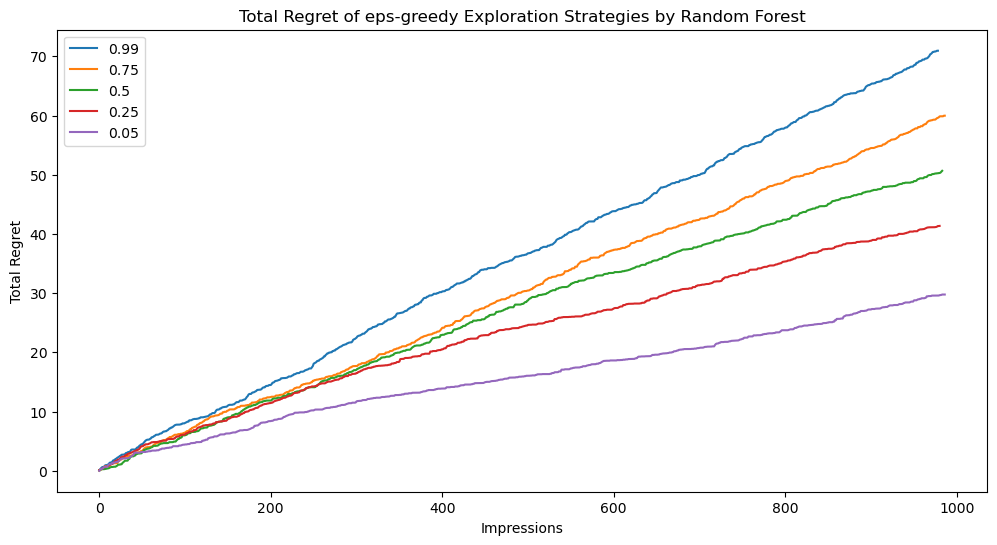

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
for e in eps:
    ax.plot(range(len(regret_vec[e])), regret_vec[e])
ax.set_ylabel('Total Regret')
ax.set_xlabel('Impressions')
ax.set_title('Total Regret of eps-greedy Exploration Strategies by Random Forest')
ax.legend(eps)
plt.show()